## LLM

In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm

print("Physical devices:", tf.config.list_physical_devices())
print("GPUs:", tf.config.list_physical_devices('GPU'))


Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
class TokenizerChar:
    def __init__(self, text):
        self.vocab = sorted(list(set(text)))
        self.vocab_size = len(self.vocab)
        char_to_idx = {ch: i for i, ch in enumerate(self.vocab)}

        vocab = list(char_to_idx.keys())
        indicies = list(char_to_idx.values())

        default_value = -1

        self.table_tokenize = tf.lookup.StaticHashTable(initializer=tf.lookup.KeyValueTensorInitializer(vocab, indicies), 
                                                        default_value=default_value)
        self.table_detokenize = tf.lookup.StaticHashTable(initializer=tf.lookup.KeyValueTensorInitializer(indicies, vocab), 
                                                          default_value="")

    
    def tokenize(self, text):
        text = tf.strings.unicode_split(text, input_encoding="UTF-8")
        indices = self.table_tokenize.lookup(text)
        return indices
    
    def detokenize(self, indices):
        text = self.table_detokenize.lookup(indices)
        text = tf.strings.reduce_join(text, axis=-1, separator="")
        return text
    

class DenseLayer():
    def __init__(self, input_dim, output_dim):
        d = tf.sqrt(tf.cast(input_dim, tf.float32))
        self.W = tf.Variable(tf.random.uniform([input_dim, output_dim], -1/d, 1/d))
        self.b = tf.Variable(tf.zeros([output_dim]))

        self.parameter_list = [self.W, self.b]

    def __call__(self, x):
        return tf.linalg.matmul(x, self.W) + self.b

    
class Transformer:
    def __init__(self, 
                 vocab_size, 
                 max_seq_len,
                 heads,
                 embed_dim,
                 key_dim,
                 ffnn_dims,
                 unembed_dims): 
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.heads = heads
        self.max_seq_len = max_seq_len
        self.key_dim = key_dim
        self.ffnn_dims = ffnn_dims
        self.unembed_dims = unembed_dims

        self.head_dim = embed_dim // heads

        d = tf.sqrt(tf.cast(self.embed_dim, tf.float32))

        self.word_embed = tf.Variable(tf.random.uniform([vocab_size, embed_dim], -1/d, 1/d))
        self.pos_embed = tf.Variable(tf.random.uniform([max_seq_len, embed_dim], -1/d, 1/d))

        self.WK =  tf.Variable(tf.random.uniform([heads, key_dim, embed_dim], -1/d, 1/d))
        self.WQ =  tf.Variable(tf.random.uniform([heads, key_dim, embed_dim], -1/d, 1/d))
        self.WV =  tf.Variable(tf.random.uniform([heads, self.head_dim, embed_dim], -1/d, 1/d))


        self.ffnn_dims.insert(0, embed_dim)
        self.ffnn_dims.append(embed_dim)
        self.ffnn_layers = []
        for i in range(len(ffnn_dims)-1):
             self.ffnn_layers.append(DenseLayer(ffnn_dims[i], ffnn_dims[i+1]))

        self.unembed_dims.insert(0, embed_dim)
        self.unembed_dims.append(vocab_size)   
        self.unembed_layers = []
        for i in range(len(unembed_dims)-1):
            self.unembed_layers.append(DenseLayer(unembed_dims[i], unembed_dims[i+1]))
        
        self.ln1 = tf.keras.layers.LayerNormalization(axis=-1,
                                              epsilon=1e-5,
                                              center=True,  # makes β
                                              scale=True)   # makes γ
        self.ln2 = tf.keras.layers.LayerNormalization(axis=-1,
                                              epsilon=1e-5,
                                              center=True,  # makes β
                                              scale=True)   # makes γ



        self.parameter_list = [self.word_embed, self.pos_embed, 
                               self.WK, self.WQ, self.WV]
        for layer in self.ffnn_layers:
            self.parameter_list += layer.parameter_list
        for layer in self.unembed_layers:
            self.parameter_list += layer.parameter_list

        self.parameter_list += self.ln1.trainable_variables
        self.parameter_list += self.ln2.trainable_variables
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    def pred(self, x):

        x_embeds = self.embed(x)
        x_embeds = self.attention(x_embeds)
        x_embeds = self.ffnn(x_embeds)
        y_pred = self.unembed(x_embeds)

        return y_pred
    
    
    def embed(self, x):
        length = tf.shape(x)[0]
        if length > self.max_seq_len:
            x = x[-self.max_seq_len:]
            length = self.max_seq_len
        x_embeds = tf.nn.embedding_lookup(self.word_embed, x)
        x_embeds = x_embeds + self.pos_embed[:length, :]

        return x_embeds
    

    def attention(self, x_embeds):
        length = tf.shape(x_embeds)[0]

        x_k = tf.einsum('ikl, jl -> ijk', self.WK, x_embeds)
        x_q = tf.einsum('ikl, jl -> ijk', self.WQ, x_embeds)
        x_v = tf.einsum('ikl, jl -> ijk', self.WV, x_embeds)

        inner = tf.einsum('ijl,ikl -> ijk', x_k, x_q)
        mask = tf.linalg.band_part(tf.ones((1, length, length), dtype = tf.bool), -1, 0)
        mask = tf.repeat(mask, self.heads, axis=0)

        inner_masked = tf.where(mask, inner, tf.constant(-np.inf))

        dk = tf.sqrt(tf.cast(self.key_dim, tf.float32))
        WA = tf.nn.softmax(inner_masked/dk, axis=-1)


        head_outs = WA @ x_v
        concat   = tf.transpose(head_outs, [1,0,2])  # [seq, heads, head_dim]
        out   = tf.reshape(concat, [length, self.embed_dim])
     
        x_embeds = x_embeds + out
        x_embeds = self.ln1(x_embeds)

        return x_embeds
    

    def ffnn(self, x_embeds):
        x_up = x_embeds
        for layer in self.ffnn_layers[:-1]:
            x_up = layer(x_up)
            x_up = tf.nn.relu(x_up)
        x_down = self.ffnn_layers[-1](x_up)

        x_embeds = x_embeds + x_down
        x_embeds = self.ln2(x_embeds)
        return x_embeds
        
    
    def unembed(self, x_embeds):
        for layer in self.unembed_layers[:-1]:
            x_embeds = layer(x_embeds)
            x_embeds = tf.nn.relu(x_embeds)
        
        x_embeds = self.unembed_layers[-1](x_embeds)
        y_pred = tf.nn.softmax(x_embeds, axis=-1)
        return y_pred

    
    @tf.function
    def train_step(self, indices_list, y_true_list, update=True):
        
        if update:
            with tf.GradientTape() as tape:
                loss_total = 0
                for indices, y_true in zip(indices_list, y_true_list):
                    y_true = y_true[1:]
                    y_pred = self.pred(indices)[:-1]
                    loss = CrossEntropyLoss(y_true, y_pred)
                    loss_total += loss
                loss = loss_total / len(indices_list)

            grads = tape.gradient(loss, self.parameter_list)
            self.optimizer.apply_gradients(zip(grads, self.parameter_list))
            return loss
        else:
            loss_total = 0
            for indices, y_true in zip(indices_list, y_true_list):
                y_true = y_true[1:]
                y_pred = self.pred(indices)[:-1]
                loss = CrossEntropyLoss(y_true, y_pred)
                loss_total += loss
            loss = loss_total / len(indices_list)
            return loss

    
def CrossEntropyLoss(y_true, y_pred):
    loss = -tf.reduce_mean(y_true * tf.math.log(y_pred + 1e-10))
    return loss


In [8]:
import os

def read_first_n(directory_path, n):
    # List all entries in the directory
    filenames = os.listdir(directory_path)
    # Filter to only .txt files
    txt_files = [f for f in filenames if f.lower().endswith('.story')]
    # Sort alphabetically (or by any other criteria you like)
    #txt_files.sort()
    # Take the first n
    first_n = txt_files[:n]
    
    contents = []
    for fname in first_n:
        full_path = os.path.join(directory_path, fname)
        with open(full_path, 'r', encoding='utf-8') as f:
            contents.append(f.read())
    return contents

In [9]:
contents = read_first_n('stories', 1000)

In [10]:
text = ""

for i in range(1000):
    text += contents[i]

tokenizer = TokenizerChar(text)
print(tokenizer.vocab_size)
print(tokenizer.vocab)

137
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '\xa0', '¢', '£', '§', '©', '«', '¬', '\xad', '¯', '°', '±', '¹', 'º', '»', '¼', '½', 'Â', 'Ã', 'Ä', 'Å', 'á', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ö', 'ø', 'ú', 'ü', 'ć', 'ł', 'š', 'Ÿ', 'ž', '˚', '̄', '\u200b', '—', '‚', '”', '„', '•', '′', '₩', '€']


In [14]:
print(contents[2])

Kansas City, Missouri (CNN) -- The General Services Administration, already under investigation for lavish spending, allowed an employee to telecommute from Hawaii even though he is based at the GSA's Kansas City, Missouri, office, a CNN investigation has found.

It cost more than $24,000 for the business development specialist to travel to and from the mainland United States over the past year.

He is among several hundred GSA "virtual" workers who also travel to various conferences and their home offices, costing the agency millions of dollars over the past three years.

Under the program, employees work from home and may live in another state from the region in which they're actually assigned.

The Kansas City employee, who started his job in January 2011, is paid $84,440 and works from his home in Honolulu, a GSA representative confirmed.

In the past year, according to GSA travel records, the employee has flown back to the mainland nine times for conferences and meetings. Four of 

## Define Model

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

embed_dim = 4000
heads = 10
max_seq_len = 200

key_dim = 64

ffnn_dims = [4000, 4000]
unembed_dims = [1000]

transformer = Transformer(vocab_size=tokenizer.vocab_size,
                          max_seq_len=max_seq_len,
                          embed_dim=embed_dim,
                          heads=heads,
                          key_dim=key_dim,
                          ffnn_dims=ffnn_dims,
                          unembed_dims=unembed_dims)

losses_train = []
losses_test = []


In [32]:
text = "ezs livurn hzlsen uvrhlzs keu rhvzls kevurhnlez skuvh rnzsl ekuh rvn zls ezs lezs livurn hzlsen uvrhlzs keu rhvzls kevurhnlez skuvh rnzsl ekuh rvn zls ezs livurn hzlsen uvrhlzs keu rhvzls kevurhnlez skuvh rnzsl ekuh rvn zlseu rhvzls kevurhnlez skuvh rnzsl ekuh rvn zlseu rhvzls kevurhnlez skuvh rnzsl ekuh rvn zls"
text = text[:80]
indices = tokenizer.tokenize(text)
transformer.pred(indices)

<tf.Tensor: shape=(80, 137), dtype=float32, numpy=
array([[0.00690688, 0.00660919, 0.00490721, ..., 0.00636599, 0.00969028,
        0.00637311],
       [0.0056459 , 0.00706819, 0.00767037, ..., 0.00389686, 0.00960096,
        0.00496214],
       [0.00986764, 0.00751769, 0.00609605, ..., 0.0063965 , 0.00632046,
        0.01029059],
       ...,
       [0.00812536, 0.00882361, 0.00913919, ..., 0.0056879 , 0.00709312,
        0.00774   ],
       [0.00768392, 0.0052058 , 0.00661971, ..., 0.00799643, 0.00962167,
        0.00706666],
       [0.00615222, 0.00642451, 0.00714575, ..., 0.00370896, 0.01084779,
        0.00694313]], dtype=float32)>

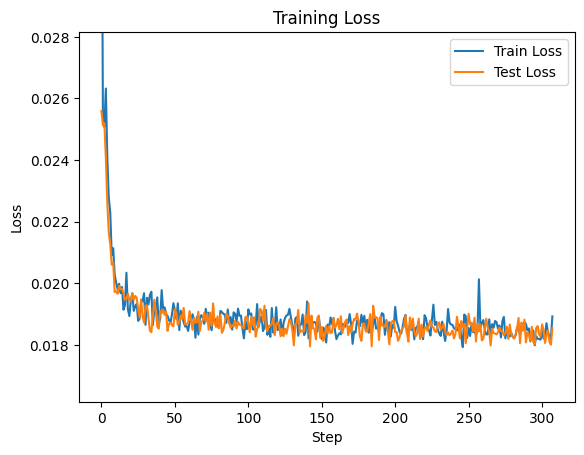

In [ ]:
batch_size = 16

for i in tqdm(range(10000)):
    indices_train_list = []
    y_true_train_list = []
    indices_test_list = []
    y_true_test_list = []
    for b in range(batch_size):
        idx = np.random.randint(0, 900)
        text = contents[idx]
        length = len(text)
        if length < max_seq_len:
            chunk = text
        else:
            start = np.random.randint(0, length - max_seq_len)
            chunk = text[start:start + max_seq_len]
        chunk = text[start:start + max_seq_len]
        indices = tokenizer.tokenize(chunk)

        y_true = tf.one_hot(indices, depth=tokenizer.vocab_size)
        y_true = tf.cast(y_true, tf.float32)

        indices_train_list.append(indices)
        y_true_train_list.append(y_true)

        idx = np.random.randint(900, 1000)
        text = contents[idx]
        length = len(text)
        start = np.random.randint(0, length - max_seq_len)
        chunk = text[start:start + max_seq_len]
        indices = tokenizer.tokenize(chunk)

        y_true = tf.one_hot(indices, depth=tokenizer.vocab_size)
        y_true = tf.cast(y_true, tf.float32)

        indices_test_list.append(indices)
        y_true_test_list.append(y_true)
    
    
    loss_train = transformer.train_step(indices_train_list, y_true_train_list)
    loss_test = transformer.train_step(indices_test_list, y_true_test_list, update = False)
    
    losses_train.append(loss_train)
    losses_test.append(loss_test)

    clear_output(wait=True)
    x = np.arange(max(0, len(losses_train)-400), len(losses_train))
    plt.plot(x, losses_train[-400:], label="Train Loss")
    plt.plot(x, losses_test[-400:], label="Test Loss")

    plt.ylim(0.9*np.min(losses_test[-400:]), 1.1*np.max(losses_test[-400:]))
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    

In [18]:
idx = np.random.randint(500)
text = contents[idx][:1000]

print(text)

(CNN) -- Lazio will play its next two European matches behind closed doors after football authorities punished the Italian club for several offenses, including a fourth charge of racist behavior this season.

European football's governing body also fined Lazio €40,000 ($52,000) following incidents in last week's Europa League round of 32 tie with German side Borussia Monchengladbach.

Lazio had already been fined a total of $230,000 for racist abuse and other fan offenses during two group-stage matches with English team Tottenham Hotspur and another against Slovenia's Maribor.

The Rome-based team has appealed UEFA's latest decision, which was handed down for "setting off and throwing fireworks, racist behavior and insufficient organization."

"The control and disciplinary body decided to order Lazio to play their next two UEFA competition matches as host club behind closed doors," read UEFA's statement.

It applies to the home leg of Lazio's last-16 clash in the second-tier competitio

In [19]:
text = 'Who is Einstein? '
indices = tokenizer.tokenize(text)
print(indices.numpy())

[53 67 74  1 68 78  1 35 68 73 78 79 64 68 73 29  1]


In [20]:
for i in range(128):
    y_pred = transformer.pred(indices)
    argmax = tf.cast(tf.argmax(y_pred[-1], axis=-1), dtype=tf.int32)
    indices = tf.concat([indices, [argmax]], axis=0)
    #print(indices)
    text_pred = tokenizer.detokenize(indices)
    print(text_pred.numpy().decode("utf-8"), end='\r', flush=True)
    time.sleep(0.05)


KeyboardInterrupt: 

In [ ]:
print(tokenizer.vocab)
print(len(tokenizer.vocab))

['\n', ' ', '!', '"', '$', "'", ',', '-', '.', '0', '1', '3', '8', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'â', 'œ', '“', '”', '€', '™']
73


## 